In [145]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import AerBackend
from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt
import numpy as np
from pytket.circuit import QControlBox, CircBox, StatePreparationBox, OpType
from pytket.backends.backendresult import BackendResult
from pytket.utils import QubitPauliOperator, gen_term_sequence_circuit
from pytket import Qubit, Circuit
from pytket.passes import DecomposeBoxes
from pytket.predicates import CompilationUnit
from pytket.circuit.display import render_circuit_jupyter
from pytket.pauli import Pauli, QubitPauliString

# First method

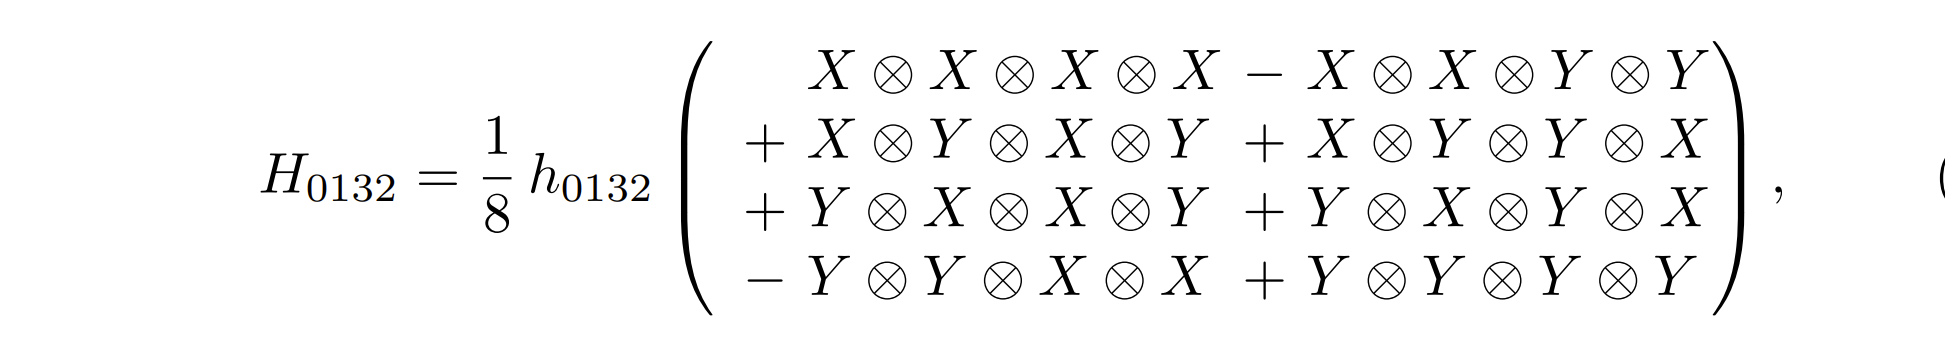

In [7]:
def build_u_t_approximation() -> Circuit:
    # t is pi/2
    # 1 Trotter step

    xxxx = QubitPauliString({Qubit(0):Pauli.X, Qubit(1):Pauli.X, Qubit(2):Pauli.X, Qubit(3):Pauli.X})
    xxyy = QubitPauliString({Qubit(0):Pauli.X, Qubit(1):Pauli.X, Qubit(2):Pauli.Y, Qubit(3):Pauli.Y})
    xyxy = QubitPauliString({Qubit(0):Pauli.X, Qubit(1):Pauli.Y, Qubit(2):Pauli.X, Qubit(3):Pauli.Y})
    xyyx = QubitPauliString({Qubit(0):Pauli.X, Qubit(1):Pauli.Y, Qubit(2):Pauli.Y, Qubit(3):Pauli.X})
    yxxy = QubitPauliString({Qubit(0):Pauli.Y, Qubit(1):Pauli.X, Qubit(2):Pauli.X, Qubit(3):Pauli.Y})
    yxyx = QubitPauliString({Qubit(0):Pauli.Y, Qubit(1):Pauli.X, Qubit(2):Pauli.Y, Qubit(3):Pauli.X})
    yyxx = QubitPauliString({Qubit(0):Pauli.Y, Qubit(1):Pauli.Y, Qubit(2):Pauli.X, Qubit(3):Pauli.X})
    yyyy = QubitPauliString({Qubit(0):Pauli.Y, Qubit(1):Pauli.Y, Qubit(2):Pauli.Y, Qubit(3):Pauli.Y})

    H = 1/8*QubitPauliOperator({xxxx:1, xxyy:-1, xyxy:1, xyyx: 1, yxxy:1, yxyx:1, yyxx:-1, yyyy:1}) #
    #We take the hamiltonian to be equal to H_{0132} for example. This allows us to have a failry complicated hamiltonian while having a reference

    circ = gen_term_sequence_circuit(H, Circuit(4))
        
    return circ

In [4]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

In [5]:
def build_phase_estimation_circuit(
    n_measurement_qubits: int, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    # Define a Circuit with a measurement and prep register
    qpe_circ: Circuit = Circuit()
    n_state_prep_qubits = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", n_measurement_qubits)
    state_prep_register = qpe_circ.add_q_register("p", n_state_prep_qubits)
    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    # Create a controlled unitary with a single control qubit
    unitary_circuit.name = "U"
    controlled_u_gate = QControlBox(CircBox(unitary_circuit), 1)

    # Add Hadamard gates to every qubit in the measurement register
    for m_qubit in measurement_register:
        qpe_circ.H(m_qubit)

    # Add all (2**n_measurement_qubits - 1) of the controlled unitaries sequentially
    for m_qubit in range(n_measurement_qubits):
        control_index = n_measurement_qubits - m_qubit - 1
        control_qubit = [measurement_register[control_index]]
        for _ in range(2**m_qubit):
            qpe_circ.add_qcontrolbox(
                controlled_u_gate, control_qubit + list(state_prep_register)
            )

    # Finally, append the inverse qft and measure the qubits
    qft_box = CircBox(build_qft_circuit(n_measurement_qubits))
    inverse_qft_box = qft_box.dagger
    qpe_circ.add_circbox(inverse_qft_box, list(measurement_register))
    qpe_circ.measure_register(measurement_register, "c")
    return qpe_circ

In [14]:
u_t_circ: Circuit = build_u_t_approximation()
u_t_box: CircBox = CircBox(u_t_circ)
u_t_circ = Circuit(4).add_gate(u_t_box, [0,1,2,3])
DecomposeBoxes().apply(u_t_circ)
render_circuit_jupyter(u_t_circ)

Now we need to analyze the structure of our Hamiltonian in order to prepare the circuit for QPE. It is indeed a sum of tensor products of Pauli $X$ and $Y$ matrices. Since all terms in the Hamiltonian commute, they can be simultaneously diagonalized, which suggests that they might share a common eigenstate or set of eigenstates. To find an eigenstate that is stabilized by all terms, we can look for a state that yields an eigenvalue when each of these Pauli operators is applied.
Given the form of the Hamiltonian terms, they seem to have a symmetry such that applying $X$ or $Y$ to all qubits will not change the state except for a possible phase factor (eigenvalue). One common eigenstate for all the $X$ operators is the  $|+\rangle^{\otimes 4}$ state, where  $|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, because the $X$ operator flips $|0\rangle$ to$|1\rangle$ and vice versa, leaving the $|+\rangle $ state unchanged up to a global phase.

A similar argument applies for the $ Y $ operators if we consider the states $ |i\rangle = \frac{1}{\sqrt{2}}(|0\rangle + i|1\rangle) $ and $ |-i\rangle = \frac{1}{\sqrt{2}}(|0\rangle - i|1\rangle) $, which are eigenstates of the $ Y $ operator with eigenvalues $ +1 $ and $ -1 $, respectively.

To prepare for QPE, we could therefore start by preparing the $ |+\rangle^{\otimes 4} $ state, which is the eigenstate of the $ X $ operator. Since all terms in the Hamiltonian are products of $ X $ and $ Y $ operators and they all commute, this state is also an eigenstate.fr Hamiltonian.

In [19]:
# prepare the  eigenstate of U(t)
prep_circuit = Circuit(4).H(0).H(1).H(2).H(3)

# Base unitary for controlled U ops
unitary_circuit = Circuit(4).add_circbox(u_t_box, [0,1,2,3]) 
qpe_circ = build_phase_estimation_circuit(
    5, state_prep_circuit=prep_circuit, unitary_circuit=unitary_circuit
)
render_circuit_jupyter(qpe_circ)

In [20]:
backend = AerBackend()
compiled_circ = backend.get_compiled_circuit(qpe_circ)
n_shots = 1000
result = backend.run_circuit(compiled_circ, n_shots)
print(result.get_counts())

Counter({(0, 0, 0, 0, 0): 876, (1, 1, 0, 0, 0): 124})


In [22]:
def plot_qpe_results(
    sim_result: BackendResult,
    n_strings: int = 4,
    dark_mode: bool = False,
    y_limit: int = 1000,
) -> None:
    """
    Plots results in a barchart given a BackendResult. the number of stings displayed
    can be specified with the n_strings argument.
    """
    counts_dict = sim_result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    if dark_mode:
        plt.style.use("dark_background")
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.75, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()

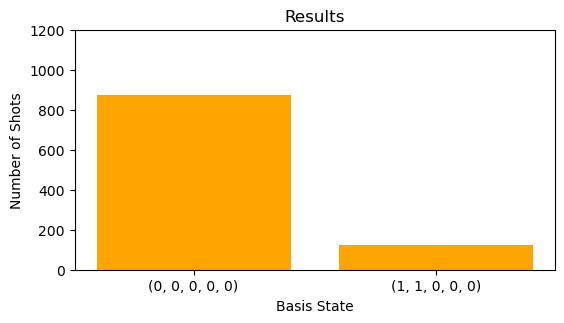

In [23]:
plot_qpe_results(result, y_limit=int(1.2 * n_shots))

In [21]:
def single_phase_from_backendresult(result: BackendResult) -> float:
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0]
    bitstring = "".join([str(bit) for bit in basis_state])
    integer_j = int(bitstring, 2)

    # Calculate theta estimate
    return integer_j / (2 ** len(bitstring))

In [24]:
theta = single_phase_from_backendresult(result)
print(theta)

0.0


# Second method

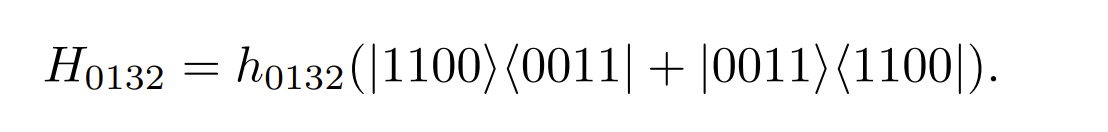

In [153]:
def TripleControlRotation() -> Circuit:
    # Create a quantum circuit
    circ = Circuit(4)
    
    # Define your rotation angle
    rotation_angle = 1 
    # Apply the triple controlled rotation gate
    # Apply the triple controlled rotation gate
    control_qubits = [0, 1, 2]
    target_qubit = [3]
    all_qubits = control_qubits + target_qubit 
    
    #basis change on target qubit to effectively get a rotation with respect to Z axis
    circ.H(3)
    circ.add_gate(OpType.CnRy, 1, all_qubits)
    circ.H(3)

    return circ

In [154]:
CCCRz: Circuit = TripleControlRotation()
CCCRz_box: CircBox = CircBox(CCCRz)
CCCRz = Circuit(4).add_gate(CCCRz_box, [0,1,2,3])
DecomposeBoxes().apply(CCCRz)
render_circuit_jupyter(CCCRz)

In [159]:

def build_u_t_approximation() -> Circuit:
    
    circ = Circuit(4)
    circ.CX(3,2)
    circ.CX(3,1)
    circ.CX(3,0)
    
    circ.H(3)


    
    # Apply an X gate to qubit 2 to flip it (anti-control)
    circ.X(2)
    
    circ.add_circbox(CCCRz_box, [0,1,2,3])
    
    
    # Apply an X gate to qubit 2 again to return it to its original state
    circ.X(2)
    
    circ.H(3)
    
    circ.CX(3,0)
    circ.CX(3,1)
    circ.CX(3,2)

    return circ

In [160]:
u_t_circ: Circuit = build_u_t_approximation()
u_t_box: CircBox = CircBox(u_t_circ)
u_t_circ = Circuit(4).add_gate(u_t_box, [0,1,2,3])
DecomposeBoxes().apply(u_t_circ)
render_circuit_jupyter(u_t_circ)

In [161]:
# prepare the  eigenstate of U(t)
prep_circuit = Circuit(4).H(0).H(1).H(2).H(3)

# Base unitary for controlled U ops
unitary_circuit = Circuit(4).add_circbox(CCCRz_box, [0,1,2,3]) 
qpe_circ = build_phase_estimation_circuit(
    5, state_prep_circuit=prep_circuit, unitary_circuit=unitary_circuit
)
render_circuit_jupyter(qpe_circ)

In [162]:
backend = AerBackend()
compiled_circ = backend.get_compiled_circuit(qpe_circ)
n_shots = 1000
result = backend.run_circuit(compiled_circ, n_shots)
print(result.get_counts())

Counter({(0, 0, 0, 0, 0): 873, (1, 1, 0, 0, 0): 66, (0, 1, 0, 0, 0): 61})


In [163]:
theta = single_phase_from_backendresult(result)
print(theta)

0.0
